In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.options.display.max_rows = 350

In [2]:
# needs to be in a separate cell, see https://github.com/ipython/ipython/issues/11098
mpl.rcParams['figure.dpi'] = 100
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
PREFIX = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data'

In [4]:
populations = (
    pd.read_csv(f'{PREFIX}/UID_ISO_FIPS_LookUp_Table.csv')
    .rename(columns=lambda x: x.replace('_', '/'))
    .convert_dtypes()
    .fillna({'Province/State': ''})
    .groupby(['Country/Region', 'Province/State'])
    .sum()
    ['Population']
    .loc()[lambda x: x > 0]
)

In [5]:
all_data = {
    loc: pd.concat({
        'cases': pd.read_csv(f'{PREFIX}/csse_covid_19_time_series/time_series_covid19_confirmed_{loc}.csv'),
        'deaths': pd.read_csv(f'{PREFIX}/csse_covid_19_time_series/time_series_covid19_deaths_{loc}.csv'),
    }, names=['values'])
    .droplevel(1)
    .convert_dtypes()
    .rename(columns=lambda x: x.replace('_', '/'))
    .fillna({'Province/State': ''})
    for loc in ['US', 'global']
}
all_data = (
    pd.concat([
        all_data['US']
        .groupby(['values', 'Country/Region', 'Province/State']).sum()
        .iloc(1)[5:-1],
        all_data['global']
        .set_index(['Country/Region', 'Province/State'], append=True)
        .iloc(1)[2:]
    ])
    .sort_index()
    .fillna({'Province/State': ''})
    .rename_axis(columns='day')
    .stack()
    .unstack(0)
    .reset_index('day')
    .assign(day=lambda x: pd.to_datetime(x['day']))
    .set_index('day', append=True)
    .join(populations, how='inner')
    .pipe(lambda df: df.apply(lambda x: x / df['Population'] * 1e6))
    .drop(columns='Population')
    .drop(index=('US', ''))
)

In [6]:
(
    all_data['cases']
    .unstack()
    .max(axis=1)
    .to_frame('maxcases')
    .join(populations)
    .sort_values('maxcases', ascending=False)
    .loc()[lambda x: x['Population'] > 1e6]
    .iloc[:30]
)

,,maxcases,Population
Country/Region,Province/State,,
US,New York,4393.797069,43022697
Spain,,3568.212476,46754783
US,New Jersey,3481.686386,17764380
Switzerland,,2936.582527,8654618
Italy,,2586.144104,60461828
Belgium,,2558.065772,11589616
US,Louisiana,2227.435254,9246060
France,,2031.314019,65273512
Ireland,,1955.325817,4937796


In [7]:
query = pd.concat([
    all_data.loc(0)[
        'US',
        ['New York', 'New Jersey', 'Louisiana', 'Massachusetts', 'Connecticut']
    ],
    all_data.loc(0)['Canada', ['Quebec']],
    all_data.loc(0)[
        [
            'Spain', 'Switzerland', 'Italy', 'Belgium', 'France',
            'Ireland', 'Portugal', 'Austria', 'Germany', 'Netherlands',
            'Israel', 'United Kingdom', 'Norway', 'Denmark', 'Sweden',

            'Czechia', 'Slovakia', 'Poland'
        ],
        ''
    ]
])

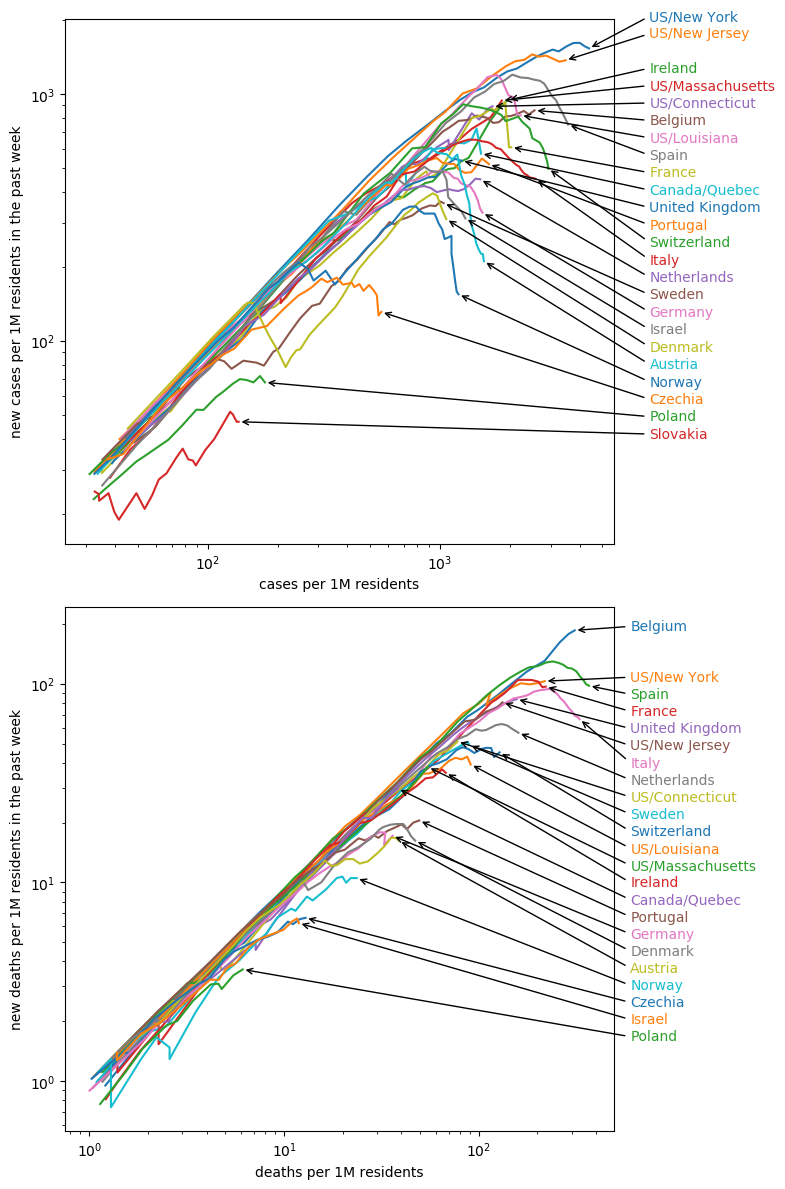

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
params = [
    ('cases', axes[0], 8_000, 1.3, 30, 0.85),
    ('deaths', axes[1], 600, 1, 1, 0.82)
]
for kind, ax, edge, start, thre, step in params:
    payload = sorted(
        [
            (
                key,
                df_i[kind].to_frame('total')
                .assign(delta=lambda x: x['total'].diff())
                .iloc()[1:]
                .assign(smdelta=lambda x: x['delta'].rolling(7).sum())
            )
            for key, df_i in query.groupby(['Country/Region', 'Province/State'])
        ],
        key=lambda x: x[1].iloc()[-1]['smdelta'],
        reverse=True,
    )
    prev_y_annot = np.inf
    for i, (key, df_i) in enumerate(payload):
        label = '/'.join(key) if key[1] else key[0]
        color = COLORS[i % len(COLORS)]
        df_i = df_i.loc()[lambda x: x['total'] >= thre]
        df_i.plot('total', 'smdelta', ax=ax, label=label, c=color)
        if not len(df_i):
            continue
        last_i = df_i.iloc()[-1]
        prev_y_annot = min(start * last_i['smdelta'], step * prev_y_annot)
        ax.annotate(
            label,
            (last_i['total'], last_i['smdelta']),
            xytext=(edge, prev_y_annot),
            color=color,
            arrowprops={
                'arrowstyle': '->',
                'relpos': (0, 0.5),
            },
        )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'{kind} per 1M residents')
    ax.set_ylabel(f'new {kind} per 1M residents in the past week')
    ax.get_legend().remove()
fig.tight_layout()